In [1]:
%cd /data/majoroval/jupyter/RS-25/homework/week02

/data/majoroval/jupyter/RS-25/homework/week02


In [2]:
import requests

import numpy as np
import polars as pl
import seaborn as sns
import matplotlib.pyplot as plt

from PIL import Image
from io import BytesIO
from textwrap import wrap
from tqdm.auto import tqdm
from concurrent.futures import ThreadPoolExecutor
from sklearn.metrics import roc_auc_score, log_loss, ndcg_score
from pprint import pprint

from framework import setup_logging, FeatureFactory, Config, DataLoader, Experiment, Visualizer
setup_logging()

<Logger lavka_recsys (DEBUG)>

# Features

In [3]:
@FeatureFactory.register('count_purchase_user_product')
def generate_count_purchase_user_product(
    history_df: pl.DataFrame, target_df: pl.DataFrame
) -> tuple[pl.DataFrame, list[str]]:
    """Count purchases by user-product pairs"""
    return history_df.filter(
        pl.col('action_type') == "AT_Purchase"
    ).group_by(
        'user_id', 'product_id'
    ).agg(
        pl.len().alias('count_purchase_u_p')
    ).join(
        target_df,
        on=['user_id', 'product_id'],
        how='right'
    ).fill_null(0)

In [4]:
@FeatureFactory.register('count_purchase_user_store')
def generate_count_purchase_user_store(
    history_df: pl.DataFrame, target_df: pl.DataFrame
) -> tuple[pl.DataFrame, list[str]]:
    """Count purchases by user-store pairs"""
    return history_df.filter(
        pl.col('action_type') == "AT_Purchase"
    ).group_by(
        'user_id', 'store_id'
    ).agg(
        pl.len().alias('count_purchase_u_s')
    ).join(
        target_df,
        on=['user_id', 'store_id'],
        how='right'
    ).fill_null(0)

In [5]:
@FeatureFactory.register('ctr_product')
def generate_ctr_product(
    history_df: pl.DataFrame, target_df: pl.DataFrame
) -> tuple[pl.DataFrame, list[str]]:
    """Calculate CTR (Click-Through Rate) for products"""
    actions = history_df.group_by(
        'action_type', 'product_id'
    ).agg(
        pl.len()
    )
    
    clicks = actions.filter(pl.col('action_type') == "AT_Click")
    views = actions.filter(pl.col('action_type') == "AT_View")
    
    feature = clicks.join(
        views, on='product_id'
    ).with_columns(
        ctr_product=pl.col('len') / pl.col('len_right')
    ).select(
        'product_id', 'ctr_product'
    )
    return target_df.join(
        feature,
        on=['product_id'],
        how='left'
    )

In [6]:
@FeatureFactory.register('recency_user_product')
def generate_recency_user_product(
    history_df: pl.DataFrame, target_df: pl.DataFrame
) -> tuple[pl.DataFrame, list[str]]:
    """Generate recency features for user-product pairs"""
    latest_time = history_df['timestamp'].max()
    
    feature = history_df.group_by(['user_id', 'product_id']).agg(
        pl.max('timestamp').alias('last_interaction_u_p')
    ).with_columns(
        days_since_interaction_u_p=(latest_time - pl.col('last_interaction_u_p')) / (24 * 60 * 60)
    )
    return target_df.join(
        feature,
        on=['user_id', 'product_id'],
        how='left'
    )

In [7]:
@FeatureFactory.register('recency_user_store')
def generate_recency_user_store(
    history_df: pl.DataFrame, target_df: pl.DataFrame
) -> tuple[pl.DataFrame, list[str]]:
    """Generate recency features for user-store pairs"""
    latest_time = history_df['timestamp'].max()
    
    feature = history_df.group_by(['user_id', 'store_id']).agg(
        pl.max('timestamp').alias('last_interaction_u_s')
    ).with_columns(
        days_since_interaction_u_s=(latest_time - pl.col('last_interaction_u_s')) / (24 * 60 * 60)
    )
    return target_df.join(
        feature,
        on=['user_id', 'store_id'],
        how='left'
    )

In [8]:
@FeatureFactory.register('user_stats')
def generate_user_stats(
    history_df: pl.DataFrame, target_df: pl.DataFrame
) -> tuple[pl.DataFrame, list[str]]:
    """Generate user-level statistics"""
    feature = history_df.group_by('user_id').agg([
        pl.len().alias('user_total_interactions'),
        pl.col('action_type').eq('AT_Purchase').sum().alias('user_total_purchases'),
        pl.col('action_type').eq('AT_View').sum().alias('user_total_views'),
        pl.n_unique('product_id').alias('user_unique_products')
    ])
    return target_df.join(
        feature,
        on=['user_id'],
        how='left'
    )

In [9]:
@FeatureFactory.register('product_stats')
def generate_product_stats(
    history_df: pl.DataFrame, target_df: pl.DataFrame
) -> tuple[pl.DataFrame, list[str]]:
    """Generate product-level statistics"""
    features = history_df.group_by('product_id').agg([
        pl.len().alias('product_total_interactions'),
        pl.col('action_type').eq('AT_Purchase').sum().alias('product_total_purchases'),
        pl.col('action_type').eq('AT_View').sum().alias('product_total_views'),
        pl.n_unique('user_id').alias('product_unique_users')
    ])
    return target_df.join(
        features,
        on=['product_id'],
        how='left'
    )

In [10]:
@FeatureFactory.register('store_stats')
def generate_store_stats(
    history_df: pl.DataFrame, target_df: pl.DataFrame
) -> tuple[pl.DataFrame, list[str]]:
    """Generate store-level statistics"""
    feature = history_df.group_by('store_id').agg([
        pl.len().alias('store_total_interactions'),
        pl.col('action_type').eq('AT_Purchase').sum().alias('store_total_purchases'),
        pl.col('action_type').eq('AT_View').sum().alias('store_total_views'),
        pl.n_unique('product_id').alias('store_unique_products')
    ])
    return target_df.join(
        feature,
        on=['store_id'],
        how='left'
    )

In [ ]:
@FeatureFactory.register('city_stats', categorical_cols=['city_name'])
def generate_city_stats(
    history_df: pl.DataFrame, target_df: pl.DataFrame
) -> tuple[pl.DataFrame, list[str]]:
    """Generate city-level statistics"""
    feature = history_df.group_by('city_name').agg([
        pl.len().alias('city_total_interactions'),
        pl.col('action_type').eq('AT_Purchase').sum().alias('city_total_purchases'),
        pl.col('action_type').eq('AT_View').sum().alias('city_total_views'),
        pl.n_unique('store_id').alias('city_unique_stores')
    ])
    # add ratio of purchases to views
    feature = feature.with_columns(
        city_purchase_view_ratio=pl.col('city_total_purchases') / pl.col('city_total_views')
    )
    # add ratio of purchases to interactions
    feature = feature.with_columns(
        city_purchase_interaction_ratio=pl.col('city_total_purchases') / pl.col('city_total_interactions')
    )
    return target_df.join(
        feature,
        on=['city_name'],
        how='left'
    )
    

# Targets

In [12]:
@FeatureFactory.register_target('CartUpdate_vs_View')
def target(history_df: pl.DataFrame, target_df: pl.DataFrame) -> pl.Series:
    """Assign 0 for 'AT_View' and 1 for 'AT_CartUpdate'."""
    mapping = {
        'AT_View': 0,
        'AT_CartUpdate': 1,
    }
    return target_df.with_columns(
        target=pl.col("action_type").map_elements(
            lambda x: mapping.get(x, None),
            return_dtype=pl.Int64
        )
    )['target']

In [13]:
@FeatureFactory.register_target('CartUpdate_Purchase_vs_View')
def target(history_df: pl.DataFrame, target_df: pl.DataFrame) -> pl.Series:
    """Assign 0 for 'AT_View' and 1 for 'AT_CartUpdate' and 'AT_Purchase'."""
    mapping = {
        'AT_View': 0,
        'AT_CartUpdate': 1,
        'AT_Purchase': 1,
    }
    return target_df.with_columns(
        target=pl.col("action_type").map_elements(
            lambda x: mapping.get(x, None),
            return_dtype=pl.Int64
        )
    )['target']

In [14]:
@FeatureFactory.register_target('CartUpdate_Purchase_vs_View')
def target(history_df: pl.DataFrame, target_df: pl.DataFrame) -> pl.Series:
    """Assign 0 for 'AT_View' and 1 for 'AT_CartUpdate' and 'AT_Purchase'."""
    mapping = {
        'AT_View': 0,
        'AT_CartUpdate': 1,
        'AT_Purchase': 1,
    }
    return target_df.with_columns(
        target=pl.col("action_type").map_elements(
            lambda x: mapping.get(x, None),
            return_dtype=pl.Int64
        )
    )['target']

In [15]:
@FeatureFactory.register_target('CartUpdate_conversion_aware')
def target(history_df: pl.DataFrame, target_df: pl.DataFrame) -> pl.Series:
    """Assign 0 for 'AT_View' and 1 for 'AT_CartUpdate' and 'AT_Purchase'."""
    conversion_action_types = ["AT_CartUpdate", "AT_Purchase", "AT_Click"]
    target_df = target_df.with_columns(
        conv=pl.col("action_type")
            .is_in(conversion_action_types)
            .any()  # any returns True if at least one conversion event is present
            .over(["request_id", "product_id"])
    )
    target_series = target_df.with_columns(
        target=pl.when(pl.col("action_type").is_in(conversion_action_types))
                    .then(1)
                    .otherwise(
                        pl.when((pl.col("action_type") == "AT_View") & (~pl.col("conv")))
                          .then(0)
                          .otherwise(None)
                    )
    )["target"]
    return target_series

# Experiments

In [16]:
config = Config()
config['features'] = [
    'count_purchase_user_product',
    # 'count_purchase_user_store',
    'ctr_product',
    # 'ctr_store',
    # 'recency_user_product',
    # 'recency_user_store',
    'user_stats',
    'product_stats',
    'store_stats',
    'city_stats',
]
config.set('history_cleaning.remove_lurkers', True)
config.set('target', 'CartUpdate_conversion_aware')

In [17]:
config.set('validation.n_folds', 2)
exp = Experiment("test", config)
results = exp.run()
results

2025-04-12 17:20:51,343 - lavka_recsys.DataLoader - INFO - Loaded train data: 14954417 rows
2025-04-12 17:20:51,356 - lavka_recsys.DataLoader - INFO - Normalized timestamps
2025-04-12 17:20:51,358 - lavka_recsys.DataLoader - INFO - Loaded test data: 565231 rows
2025-04-12 17:20:51,360 - lavka_recsys.DataLoader - INFO - Normalized timestamps
2025-04-12 17:20:51,362 - lavka_recsys.experiment=test - INFO - Saved experiment configuration to results/test_6fb246_config.json
2025-04-12 17:20:51,363 - lavka_recsys.experiment=test - INFO - Starting experiment: test_6fb246
2025-04-12 17:20:51,364 - lavka_recsys.experiment=test - INFO - Feature names: ['count_purchase_user_product', 'ctr_product', 'user_stats', 'product_stats', 'store_stats', 'city_stats']
2025-04-12 17:20:51,365 - lavka_recsys.experiment=test - INFO - Model type: catboost
2025-04-12 17:20:53,835 - lavka_recsys.DataLoader - INFO - Removed 0 users who only watch (lurkers); rows reduced from 3224400 to 3205114
2025-04-12 17:20:54,6

cv:   0%|          | 0/2 [00:00<?, ?it/s]

2025-04-12 17:20:54,705 - lavka_recsys.experiment=test - INFO - Processing fold 1/2
2025-04-12 17:20:54,707 - lavka_recsys.FeatureFactory - INFO - Generating features: count_purchase_user_product, ctr_product, user_stats, product_stats, store_stats, city_stats


ColumnNotFoundError: city_total_purchases

Resolved plan until failure:

	---> FAILED HERE RESOLVING 'sink' <---
DF ["action_type", "city_name", "position_in_request", "product_category", ...]; PROJECT */12 COLUMNS

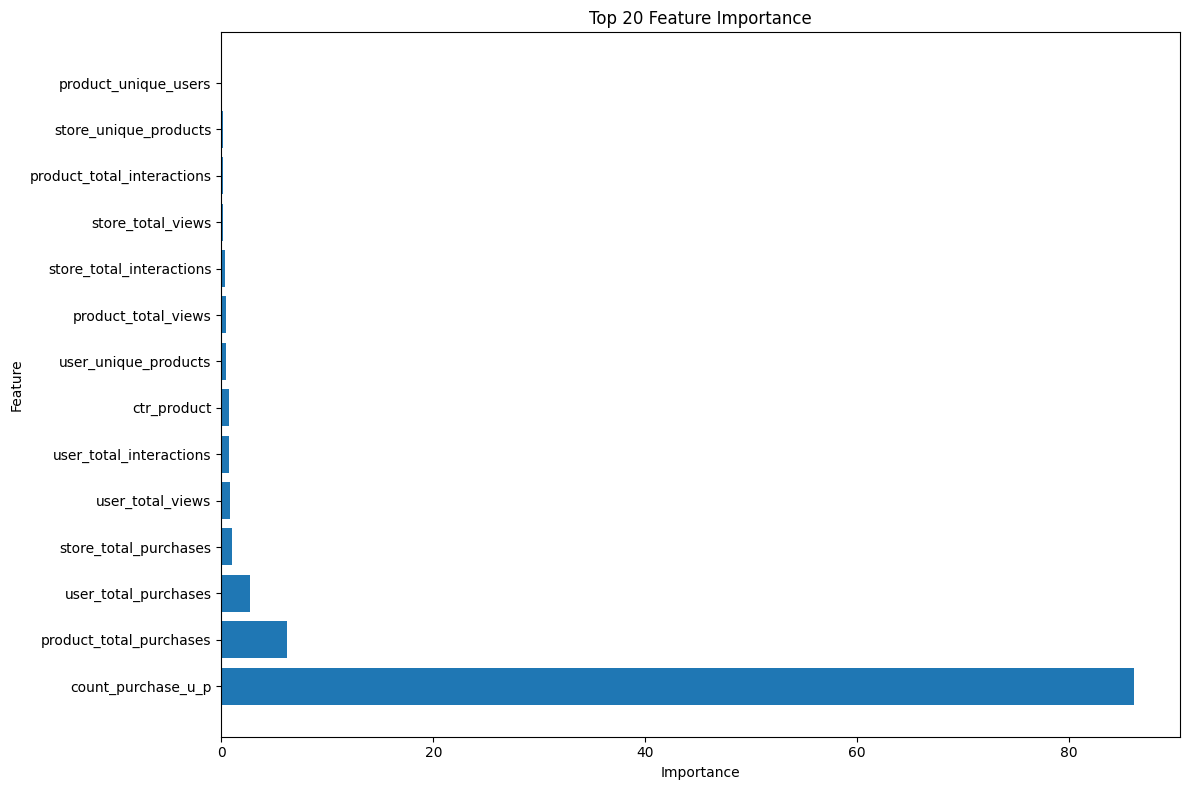

In [18]:
vis = Visualizer()
vis.plot_feature_importance(results['cv_results']['folds'][0]['feature_importance']);

In [19]:
config.set('history_cleaning.remove_lurkers', True)
exp = Experiment("test-w-lurkers-conv-aware", config)
preds = exp.predict({'iterations': 100})

2025-04-12 17:10:45,068 - lavka_recsys.DataLoader - INFO - Loaded train data: 14954417 rows
2025-04-12 17:10:45,080 - lavka_recsys.DataLoader - INFO - Normalized timestamps
2025-04-12 17:10:45,081 - lavka_recsys.DataLoader - INFO - Loaded test data: 565231 rows
2025-04-12 17:10:45,084 - lavka_recsys.DataLoader - INFO - Normalized timestamps
2025-04-12 17:10:45,086 - lavka_recsys.experiment=test-w-lurkers-conv-aware - INFO - Saved experiment configuration to results/test-w-lurkers-conv-aware_e14a2e_config.json


TypeError: Experiment.predict() takes 1 positional argument but 2 were given